### Building Network Models
### UB Species-collectors Network
# Connected Components

---

In [1]:
import paths

In [2]:
import pandas as pd

%matplotlib inline

### Reading occurrences dataset

In [39]:
dsetPath = '/home/pedro/datasets/ub_herbarium/occurrence.txt'
cols=['recordedBy','scientificName','taxonRank','kingdom','phylum','class','order','family','genus','species',
      'countryCode','stateProvince', 'rightsHolder', 'repatriated', 'occurrenceRemarks', 'eventDate']

occs = pd.read_table(dsetPath,usecols=cols,low_memory=False)
occs = occs[occs['recordedBy'].notnull()]
occs = occs[occs['scientificName'].notnull()]
occs = occs[occs['species'].notnull()]

---

### Building the SCN model

In [4]:
# Names Atomization
from caryocar.cleaning import NamesAtomizer,namesFromString

names_replaces_file = '/home/pedro/caryocar/caryocar/cleaning/data/ub_collectors_replaces.json'
na = NamesAtomizer(atomizeOp=namesFromString)
na.read_replaces(names_replaces_file)
occs['recordedBy_atomized']=na.atomize(occs['recordedBy'])

# Names Map
from caryocar.cleaning import normalize,read_NamesMap_fromJson
collectors_names = list(set( n for n,st,num in na.getCachedNames()))


nm = read_NamesMap_fromJson('/home/pedro/caryocar/caryocar/cleaning/data/ub_namesmap.json',
                             normalizationFunc=normalize)
nm.addNames(collectors_names)

# Names index
from caryocar.cleaning import getNamesIndexes
ni = getNamesIndexes(occs, 'recordedBy_atomized',namesMap=nm.getMap())

# Network model
from caryocar.models import SpeciesCollectorsNetwork

scn = SpeciesCollectorsNetwork(species=occs['species'],collectors=occs['recordedBy_atomized'],namesMap=nm)

cols_to_filter = ['','ignorado','ilegivel','incognito','etal']
scn.remove_nodes_from(cols_to_filter)

---

# Connected Components

Obtain subgraphs from isolated components. The first one (considering the list is ordered by number of nodes) is the giant component.

In [5]:
sgs = sorted( scn.connectedComponentsSubgraphs(), key=lambda g: len(g.nodes()), reverse=True )

##### Top-10 connected components

In [6]:
lines=[ 
    "Graph {}: {} collectors; {} species".format( i,len(sg.listCollectorsNodes()),len(sg.listSpeciesNodes()) ) 
                                                        for i,sg in enumerate(sgs) ]

for l in lines[:10]:
    print(l)

Graph 0: 6334 collectors; 14757 species
Graph 1: 3 collectors; 141 species
Graph 2: 6 collectors; 5 species
Graph 3: 2 collectors; 7 species
Graph 4: 3 collectors; 5 species
Graph 5: 1 collectors; 7 species
Graph 6: 3 collectors; 5 species
Graph 7: 4 collectors; 4 species
Graph 8: 1 collectors; 7 species
Graph 9: 3 collectors; 4 species


* Graph 0 is the giant component
* Graph 1 is the biggest isolated component

### Graph 0

In [7]:
giant = sgs[0]

In [8]:
o=occs.loc[ set( ix for col in giant.listCollectorsNodes() for ix in ni[col]) ]

* The vast majority of records are from Brazil:

In [9]:
o['countryCode'].value_counts(normalize=True)[:10]

BR    0.951812
US    0.007904
AQ    0.007010
ID    0.003495
AU    0.002867
ZA    0.002580
MY    0.002505
FI    0.002252
PG    0.001966
SE    0.001645
Name: countryCode, dtype: float64

* Records from Brazil per state

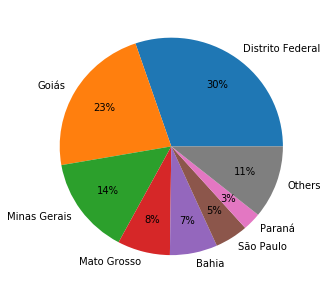

In [10]:
display=7
top5=o[o['countryCode']=='BR']['stateProvince'].value_counts(normalize=True)[:display]
others=pd.Series( o[o['countryCode']=='BR']['stateProvince'].value_counts(normalize=True)[display:].sum(), index=['Others'] )
pd.concat([top5,others]).plot(kind='pie',figsize=(5,5),label='',autopct='%1.0f%%',pctdistance=0.7)

* Number of singleton species

In [43]:
num = len([ sp for sp,cnt in giant.listSpeciesNodes(data='count') if cnt==1 ])
pctg=num/len(giant.listSpeciesNodes())

print("Number: {} ; Percentage: {}".format(num,pctg))

Number: 4983 ; Percentage: 0.3376702581825574



### Why are there so many species in Graph 1?

In [12]:
g1 = sgs[1]

* Collectors in Graph 1

In [13]:
for col,cnt in g1.listCollectorsNodes(data='count'):
    print("{}: k={}; num of records={}".format(col,g1.degree(col),cnt))

castelobranco,cw: k=57; num of records=2256
grando,jv: k=57; num of records=2256
leite,alta: k=87; num of records=2757


* Species in Graph 1

In [14]:
for sp,cnt in g1.listSpeciesNodes(data='count'):
    print("{}: k={}; num of records={}".format(sp,g1.degree(sp),cnt))

Acutodesmus acuminatus: k=2; num of records=62
Dictyosphaerium ehrenbergianum: k=2; num of records=62
Pediastrum duplex: k=2; num of records=76
Monoraphidium komarkovae: k=2; num of records=40
Coelastrum microporum: k=2; num of records=36
Trachelomonas armata: k=2; num of records=59
Chlorella vulgaris: k=2; num of records=83
Anabaenopsis raciborskii: k=2; num of records=91
Desmodesmus protuberans: k=2; num of records=61
Sphaerocystis schroeteri: k=2; num of records=80
Microcystis aeruginosa: k=2; num of records=58
Stauridium tetras: k=2; num of records=46
Desmodesmus denticulatus: k=2; num of records=51
Staurastrum subpygmaeum: k=2; num of records=79
Jaaginema pseudogeminatum: k=2; num of records=14
Oocystis borgei: k=2; num of records=17
Tetmemorus laevis: k=3; num of records=101
Staurastrum iversenii: k=2; num of records=85
Trachelomonas volvocinopsis: k=2; num of records=75
Peridinium volzii: k=2; num of records=49
Staurastrum muticum: k=3; num of records=93
Treubaria schimidlei: k=

##### Aggregate Graph 1 on rank 'phylum'

In [15]:
grp = dict( (ph,set(spp)) for ph,spp in occs[['species','phylum']].groupby('phylum')['species'] )
g1_agg = g1.taxonomicAggregation(grp)

* Species set (aggregated on rank 'phylum')

In [16]:
for sp,cnt in g1_agg.listSpeciesNodes(data='count'):
    print("Phylum {}: k={}; num of records={}".format(sp,g1_agg.degree(sp),cnt))

Phylum Charophyta: k=3; num of records=3461
Phylum Chlorophyta: k=2; num of records=1133
Phylum Cyanobacteria: k=2; num of records=214
Phylum Euglenozoa: k=2; num of records=134
Phylum Myzozoa: k=2; num of records=71


* Occurrences from this component

In [17]:
o=occs.loc[set([ i for col in g1_agg.listCollectorsNodes() for i in ni[col] ])]

In [18]:
o.head()

,rightsHolder,recordedBy,occurrenceRemarks,countryCode,stateProvince,scientificName,kingdom,phylum,class,order,family,genus,taxonRank,species,repatriated,recordedBy_atomized
57344,UB - Herbário da Universidade de Brasília,"Leite, ALTA",NaN,BR,Distrito Federal,"Phymatodocis alternans Nordstedt, 1877",Plantae,Charophyta,Zygnematophyceae,Zygnematales,Desmidiaceae,Phymatodocis,SPECIES,Phymatodocis alternans,False,"[Leite, ALTA]"
57345,UB - Herbário da Universidade de Brasília,"Leite, ALTA",NaN,BR,Distrito Federal,Xanthidium mammillosum var. mammillosum,Plantae,Charophyta,Zygnematophyceae,Zygnematales,Desmidiaceae,Xanthidium,VARIETY,Xanthidium mamillosum,False,"[Leite, ALTA]"
57346,UB - Herbário da Universidade de Brasília,"Leite, ALTA",NaN,BR,Distrito Federal,Triploceras gracile subsp. bidentatum Nordsted...,Plantae,Charophyta,Zygnematophyceae,Zygnematales,Desmidiaceae,Triploceras,SUBSPECIES,Triploceras gracile,False,"[Leite, ALTA]"
57347,UB - Herbário da Universidade de Brasília,"Leite, ALTA",NaN,BR,Distrito Federal,Staurodesmus wandae var. wandae,Plantae,Charophyta,Zygnematophyceae,Zygnematales,Desmidiaceae,Staurodesmus,VARIETY,Staurodesmus wandae,False,"[Leite, ALTA]"
57348,UB - Herbário da Universidade de Brasília,"Leite, ALTA",NaN,BR,Distrito Federal,Staurastrum stelliferum var. evolutum K.Thomasson,Plantae,Charophyta,Zygnematophyceae,Zygnematales,Desmidiaceae,Staurastrum,VARIETY,Staurastrum stelliferum,False,"[Leite, ALTA]"


* All records are from Distrito Federal (BR)

In [19]:
o['stateProvince'].value_counts()

Distrito Federal    5013
Name: stateProvince, dtype: int64

### Graphs 1 and beyond

In [20]:
isolatedComponents = sgs[1:]

collectors = [ col for g in isolatedComponents for col in g.listCollectorsNodes() ]
species = [ sp for g in isolatedComponents for sp in g.listSpeciesNodes() ]

o = occs.loc[ set( i for c in collectors for i in ni[c] ) ]

In [21]:
o['countryCode'].value_counts(normalize=True)[:10]

BR    0.929675
US    0.021261
AU    0.008177
CO    0.003089
AR    0.002362
ZA    0.001999
MX    0.001817
SE    0.001454
ZZ    0.001454
PS    0.001454
Name: countryCode, dtype: float64

In [22]:
o.shape[0]

5517

### Graphs 2 and beyond

In [23]:
isolatedComponents = sgs[2:]

In [24]:
collectors = [ col for g in isolatedComponents for col in g.listCollectorsNodes() ]
species = [ sp for g in isolatedComponents for sp in g.listSpeciesNodes() ]

In [25]:
o = occs.loc[ set( i for c in collectors for i in ni[c] ) ]

* As opposed to the giant component, only 21% of records are from Brazil. From all countries, US holds the higher percentage.

In [26]:
o['countryCode'].value_counts(normalize=True)[:10]

US    0.238776
BR    0.210204
AU    0.091837
CO    0.034694
AR    0.026531
ZA    0.022449
MX    0.020408
ZZ    0.016327
SE    0.016327
PS    0.016327
Name: countryCode, dtype: float64

In [27]:
o[o['countryCode']=='BR']['stateProvince'].value_counts(normalize=True)

São Paulo              0.310680
Rio de Janeiro         0.135922
Minas Gerais           0.135922
Distrito Federal       0.077670
Bahia                  0.067961
Rio Grande do Sul      0.048544
Pará                   0.048544
Amazonas               0.029126
Paraná                 0.029126
Roraima                0.029126
Mato Grosso            0.019417
Mato Grosso do Sul     0.019417
Rio Grande do Norte    0.019417
Rondônia               0.009709
Espírito Santo         0.009709
Ceará                  0.009709
Name: stateProvince, dtype: float64